In [1]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
#----------------------------------------------------------------
# Load LIGO data from a single file
#----------------------------------------------------------------
# First from H1
fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:
fs = 4096
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

In [3]:
# read in the NR template
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

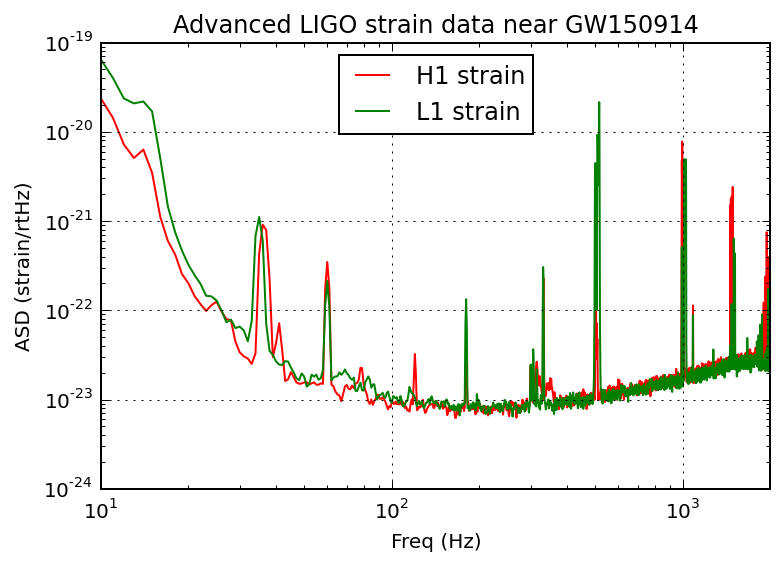

In [4]:

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_ASDs.png')

In [5]:
# Whiten
# copied from LIGO tutorial

# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

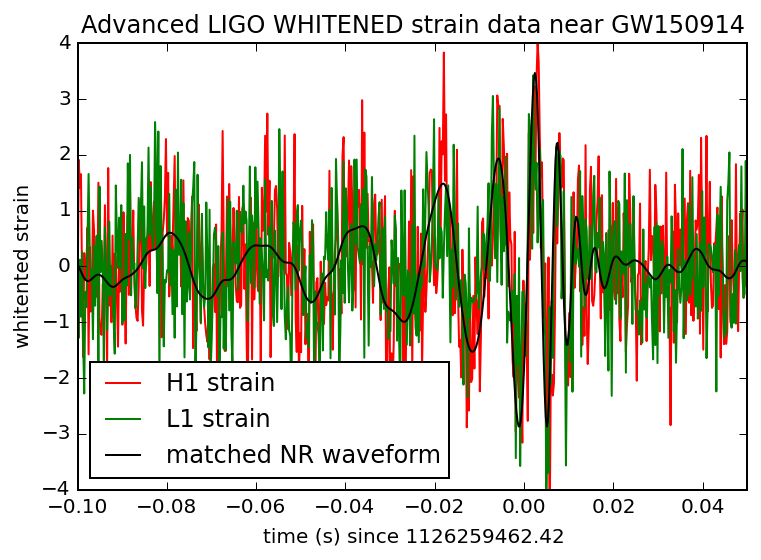

In [9]:
# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!

NR_H1_whitenbp     = NR_H1_whiten #FIXME
strain_L1_whitenbp = strain_L1_whiten #FIXME
strain_H1_whitenbp = strain_H1_whiten #FIXME
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event

strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

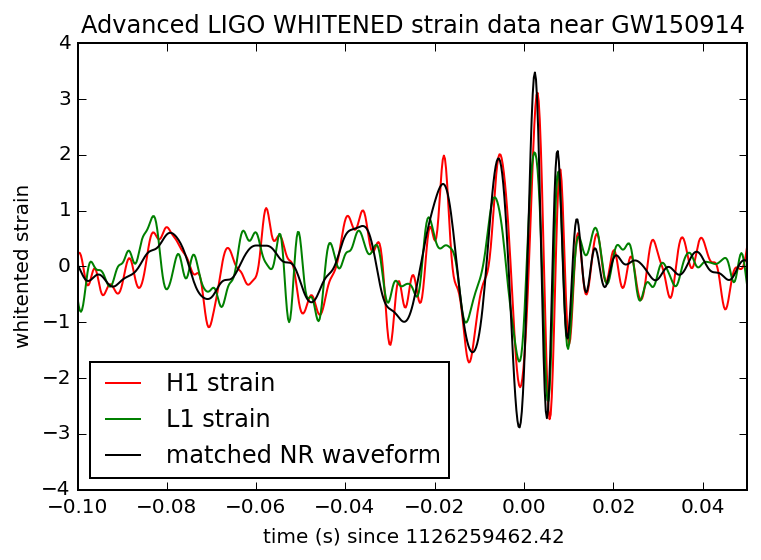

In [11]:
# Bandpass filter in the time domain (as in the tutorial)
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)
NR_H1_whitenbp = filtfilt(bb, ab, NR_H1_whiten)

strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

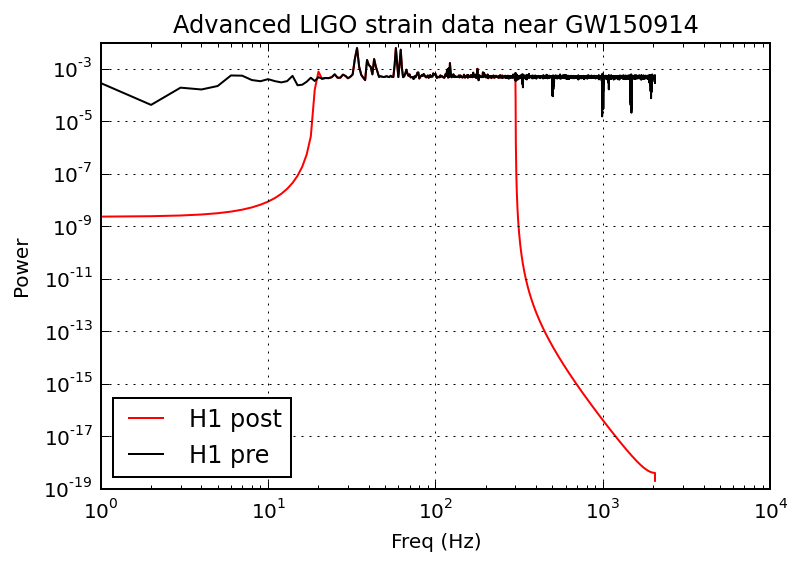

In [19]:
# Compare PSD before and after filtering
pre_Pxx_H1, freqs = mlab.psd(strain_H1_whiten, Fs = fs, NFFT = NFFT)
pre_Pxx_L1, freqs = mlab.psd(strain_L1_whiten, Fs = fs, NFFT = NFFT)
post_Pxx_H1, freqs = mlab.psd(strain_H1_whitenbp, Fs = fs, NFFT = NFFT)
post_Pxx_L1, freqs = mlab.psd(strain_L1_whitenbp, Fs = fs, NFFT = NFFT)

plt.figure()
# plot the PSDs:
plt.figure()
plt.loglog(freqs, post_Pxx_H1,'-r',label='H1 post')
plt.loglog(freqs, pre_Pxx_H1,'-k',label='H1 pre')
#plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('Power')
plt.xlabel('Freq (Hz)')
plt.legend(loc='lower left')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_ASDs.png')

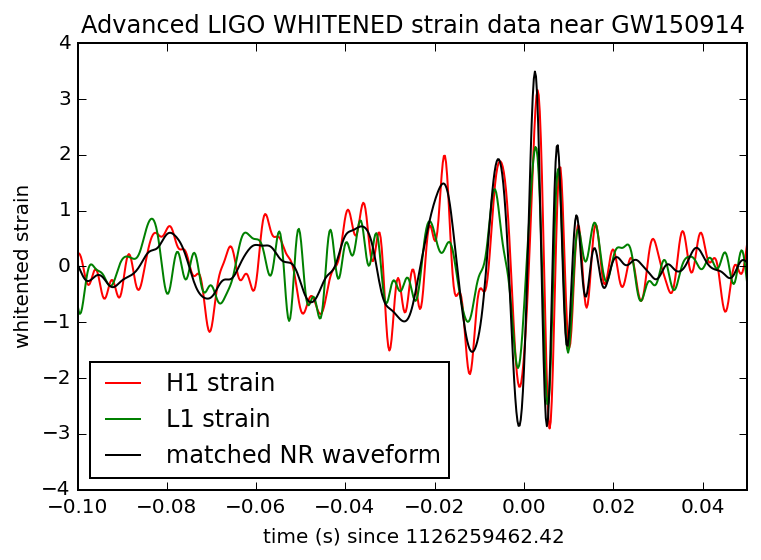

In [18]:
# Bandpass filter in the time domain (as in the tutorial)
def bandpass_freq_domain(x, fs, f1, f2):
    # transform to frequency domain
    Nt = len(x)
    freqs = np.fft.rfftfreq(Nt, dt)
    X = np.fft.rfft(x)
    
    # Set power to zero for freqs outside passband
    X_BP = [0 if f < f1 or f > f2 else XX for f,XX in zip(freqs, X)]
    
    # Inverse transform back to time domain
    x_bp = np.fft.irfft(X_BP, n=Nt)
    return x_bp

strain_H1_whitenbp = bandpass_freq_domain(strain_H1_whiten, fs, 20., 300.)
strain_L1_whitenbp = bandpass_freq_domain(strain_L1_whiten, fs, 20., 300.)
NR_H1_whitenbp = bandpass_freq_domain(NR_H1_whiten, fs, 20., 300.)

strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')